# Comparação dos modelos
Nessa etapa, pegamos todos os modelos já na melhor configuração de parâmetros possível, e os comparamos, utilizando:
1. Relatório de classificação (Contém acurácia média, recall e f1_score)
2. Matriz de confusão (Detalhamento da acurácia)
3. Boxplot

Também apresentamos testes de significância estatística.

# Imports

In [18]:
%pip install scikit-learn
%pip install seaborn
%pip install pandas
%pip install numpy
%pip install matplotlib

import matplotlib.pyplot as plt
import seaborn
import pandas
import numpy

# Tools
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


# Definindo constantes

In [2]:
RANDOM_SEED = 1337
N_JOBS = -1

# Carregamento de dados

In [3]:
def load_data(file_path: str, positive_label_multiplication: int = 2) -> pandas.DataFrame:
    """ Receives a file path for the dataset training, testing and validation datasets. """

    # Loading data from csv file
    df = pandas.read_csv(file_path)

    # Selecting useful features
    useful_features = [
        "Bidder_Tendency",
        "Bidding_Ratio",
        "Successive_Outbidding",
        "Last_Bidding",
        "Auction_Bids",
        "Starting_Price_Average",
        "Early_Bidding",
        "Winning_Ratio",
        "Auction_Duration",
        "Class"
    ]

    df = df[useful_features]

    # Augmenting positive label data
    positive_labels = df[df["Class"] == 1]

    dfs_to_concat = [df]
    for _ in range(positive_label_multiplication):
        dfs_to_concat.append(positive_labels)

    df = pandas.concat(dfs_to_concat)
    df = df.sample(frac=1)

    # Separating features and labels
    columns = list(df.columns)
    features = columns[:len(columns)-1]
    label = columns[len(columns)-1:]

    X = df[features]
    y = df[label]

    # Creating training, testing and validation datasets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = RANDOM_SEED)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.125, random_state = RANDOM_SEED)

    return X_train, y_train, X_test, y_test, X_valid, y_valid

In [4]:
file_path = "./dataset/Shill Bidding Dataset.csv"

X_train, y_train, X_test, y_test, X_valid, y_valid = load_data(file_path)

# Repositório de modelos e parâmetros
Inicializamos um dicionário com o nome de cada modelo e sua instância, já com os melhores hiper-parâmetros.

In [26]:
model_repository = {
    "knn": KNeighborsClassifier(
        algorithm= "auto",
        leaf_size= 20,
        n_neighbors= 6,
        p= 2,
        weights= "distance",
        n_jobs= -1
    ),
    "decision tree": DecisionTreeClassifier(
        criterion= "gini",
        max_depth= 38,
        max_features= None,
        splitter= "random"
    ),
    "svm": SVC(
        C= 1.0,
        degree= 1,
        gamma= "auto",
        kernel= "rbf",
        random_state=RANDOM_SEED
    ),
    "random forest": RandomForestClassifier(
        n_estimators= 178,
        min_samples_split= 4,
        min_samples_leaf= 1,
        max_features= None,
        max_depth= 44,
        criterion= "gini",
        random_state=RANDOM_SEED,
        n_jobs= -1
    ),
    "mlp": MLPClassifier(
        solver= "lbfgs",
        max_iter= 200,
        learning_rate= "invscaling",
        hidden_layer_sizes= (100,),
        alpha= 0.0006,
        activation= "relu",
        random_state=RANDOM_SEED
    ),
    "ensemble mlp (bagging)": BaggingClassifier(
        n_estimators= 5,
        max_samples= 0.6,
        max_features= 0.8,
        bootstrap_features= False,
        bootstrap= True,
        random_state=RANDOM_SEED,
        n_jobs= -1
    ),
    "heterogeneous ensemble (voting)": VotingClassifier(
        estimators=[
            ("mlp", MLPClassifier(
                hidden_layer_sizes=(33, 33, 34,),
                activation="tanh",
                solver="lbfgs",
                random_state=RANDOM_SEED
            )),
            ("dt", DecisionTreeClassifier(
                criterion="gini",
                max_depth=38,
                max_features=None,
                splitter="random",
                random_state=RANDOM_SEED
            )),
            ("svm", SVC(
                C= 1.0,
                degree= 1,
                gamma= "auto",
                kernel= "rbf",
                random_state=RANDOM_SEED
            )),
            ("knn", KNeighborsClassifier(
                algorithm="auto",
                leaf_size=20,
                n_neighbors=6,
                p=2,
                weights="distance"
            ))
        ],
        voting= "hard",
        weights= None,
        n_jobs= -1
    )
}

# Treinamento

In [13]:
for model_name, model in model_repository.items():
    print("Training:", model_name)
    start = time.time()

    model.fit(X_train, y_train.values.ravel())

    end = round(time.time() - start, 2)
    print(f"Training of {model_name} completed in {end} seconds")

Training: knn
Training of knn completed in 0.01 seconds
Training: decision tree
Training of decision tree completed in 0.01 seconds
Training: svm
Training of svm completed in 0.16 seconds
Training: random forest
Training of random forest completed in 0.46 seconds
Training: mlp


/home/alps2/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Training of mlp completed in 3.36 seconds
Training: ensemble mlp (bagging)
Training of ensemble mlp (bagging) completed in 0.4 seconds
Training: heterogeneous ensemble (voting)
Training of heterogeneous ensemble (voting) completed in 1.54 seconds


# Resultados
Para analisar os modelos, usamos o conjunto de testes, que é separado do conjunto de treino.

Resultados do modelo: knn
Relatório de classificação:


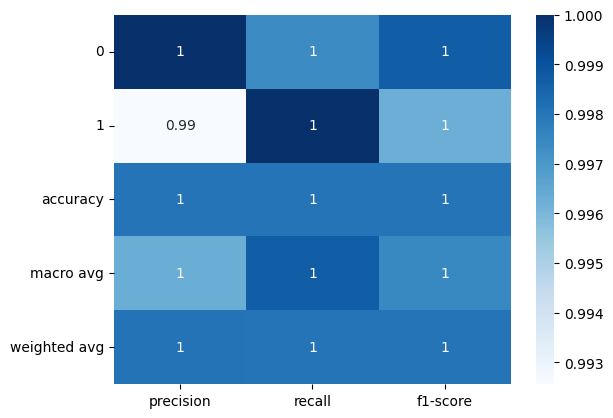

Matriz de confusão:


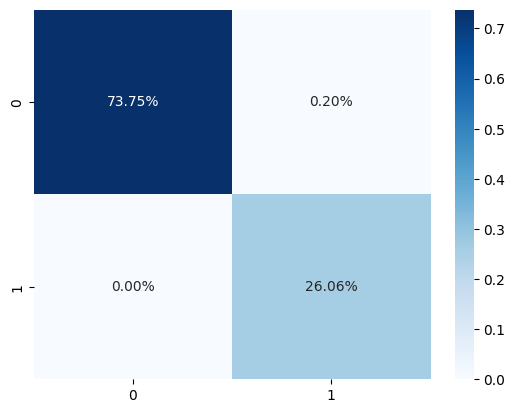

Resultados do modelo: decision tree
Relatório de classificação:


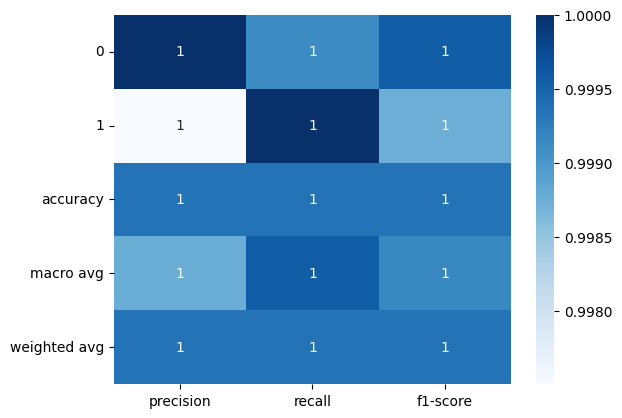

Matriz de confusão:


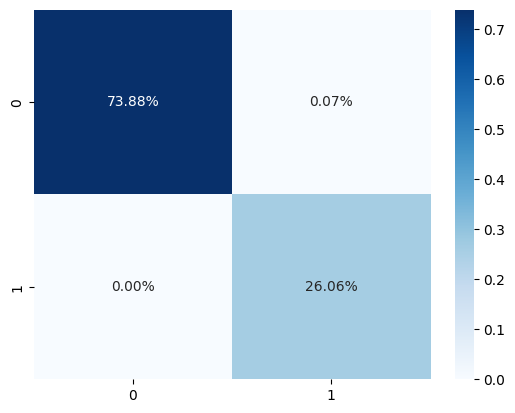

Resultados do modelo: svm
Relatório de classificação:


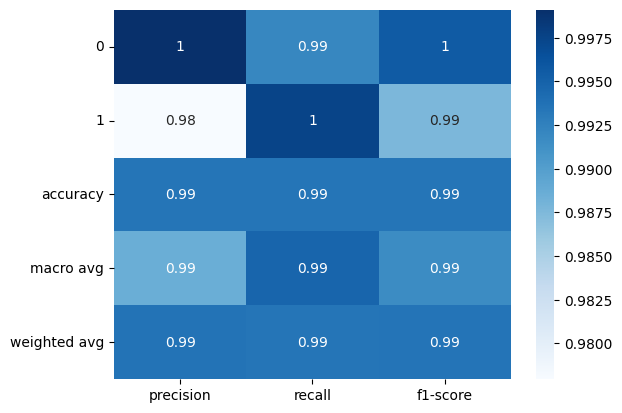

Matriz de confusão:


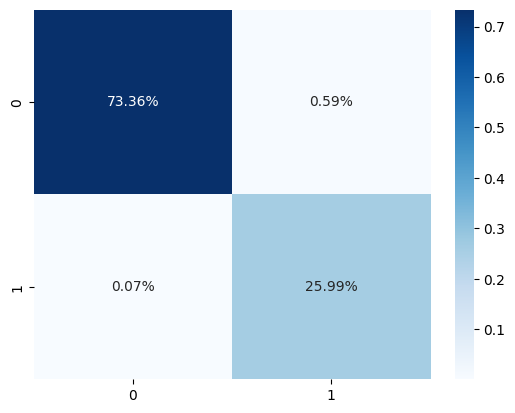

Resultados do modelo: random forest
Relatório de classificação:


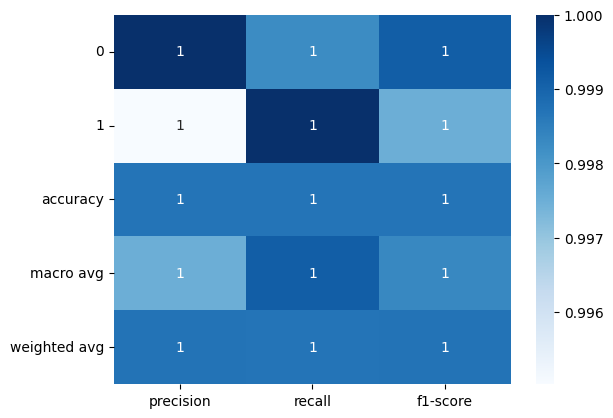

Matriz de confusão:


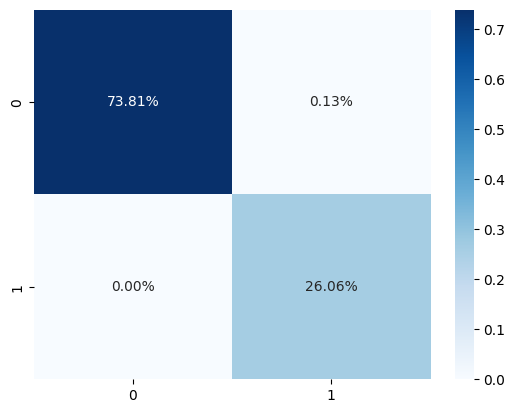

Resultados do modelo: mlp
Relatório de classificação:


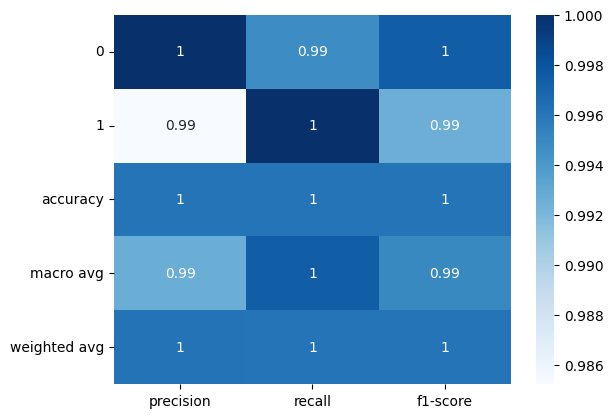

Matriz de confusão:


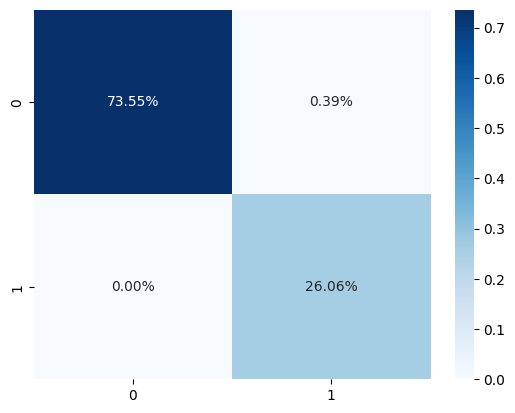

Resultados do modelo: ensemble mlp (bagging)
Relatório de classificação:


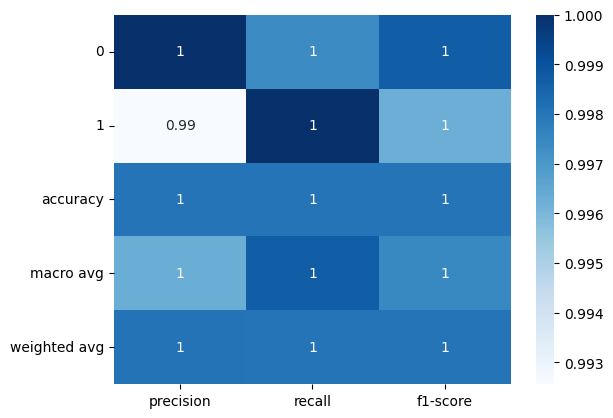

Matriz de confusão:


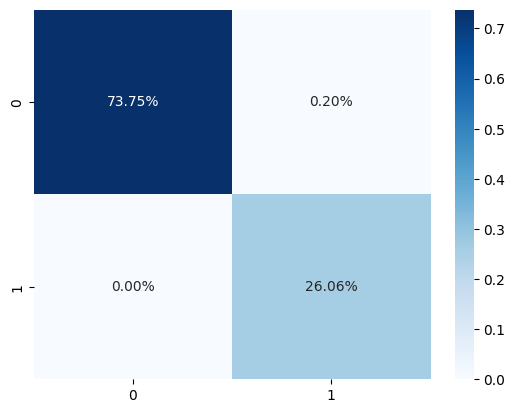

Resultados do modelo: heterogeneous ensemble (voting)
Relatório de classificação:


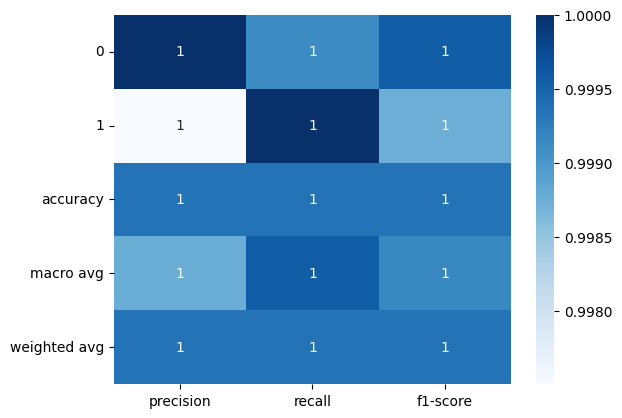

Matriz de confusão:


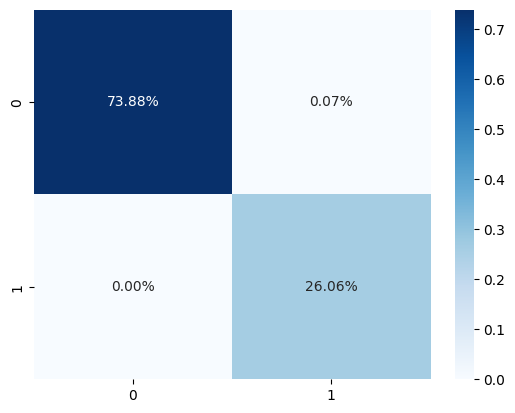

In [25]:
for model_name, model in model_repository.items():
    pred = model.predict(X_test)

    
    print("Resultados do modelo:", model_name)
    print("Relatório de classificação:")
    clf_report = classification_report(y_test, pred, output_dict=True)
    plt.figure(f"{model_name}-clf_report")
    seaborn.heatmap(pandas.DataFrame(clf_report).iloc[:-1, :].T, annot=True, cmap='Blues')
    plt.show()

    print("Matriz de confusão:")
    cf_matrix = confusion_matrix(y_test, pred)
    
    plt.figure(f"{model_name}-cf_matrix")
    seaborn.heatmap(cf_matrix/numpy.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')
    plt.show()
    print("===================================================================================================")

